In [1]:
import os
import yaml
import simpy
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from copy import deepcopy

mpl.rcParams['hatch.linewidth'] = 0.2  # previous pdf hatch linewidth

from ORBIT.core.library import initialize_library
from CORAL import SharedLibrary, GlobalManager, ProjectPipeline, InfrastructurePipeline

initialize_library(os.path.join(os.getcwd(), "library"))

# Projects
projects = os.path.join(os.getcwd(), "test_pipeline.csv")
base = os.path.join(os.getcwd(), "base_project.yaml")
project_pipeline = ProjectPipeline(projects, base)

# Infrastructure
infrastructure = os.path.join(os.getcwd(), "test_infrastructure.csv")
base = os.path.join(os.getcwd(), "base_infrastructure.yaml")
infra_pipeline = InfrastructurePipeline(infrastructure, base)

# Total Pipeline
pipeline = [*project_pipeline.configs, *infra_pipeline.configs]

# Weather
# weather = pd.read_csv("library/weather/vineyard_wind_weather_1983_2017_orbit.csv", parse_dates=['datetime']).set_index('datetime')

ORBIT library intialized at '/Users/jnunemak/repos/external/CORAL/shared_export/library'


In [20]:
allocations = {
    "wtiv": ('example_wtiv', 2),
    "feeder": ('example_feeder', 3),
    "port": [('northeast', 2), ('central', 1), ('south', 1)],
    "export_cable_install_vessel": ("example_cable_lay_vessel", 2)
}

library_path = os.path.join(os.getcwd(), "library")

env = simpy.Environment()
library = SharedLibrary(env, allocations, path=library_path)

#### Shared Export Test

In [21]:
manager = GlobalManager(pipeline, allocations, library_path=library_path)#, weather=weather)
manager.run()

In [22]:
df = pd.DataFrame(manager.logs).iloc[::-1]
df = df.reset_index(drop=True).reset_index()

In [23]:
power_reqs = dict(zip(
    project_pipeline.projects["name"],
    project_pipeline.projects["power_req"].apply(lambda x: x.split(", "))
))

df["Date Powered"] = pd.Timestamp(2000, 1, 1)
name_idx = {v: k for k, v in df["name"].to_dict().items()}

for name, reqs in power_reqs.items():
    df.loc[name_idx[name], "Date Powered"] = df.loc[df["name"].isin(reqs)]["Date Finished"].max()
    
df.loc[df["Date Powered"] < df["Date Finished"], "Date Powered"] = df.loc[df["Date Powered"] < df["Date Finished"], "Date Finished"]

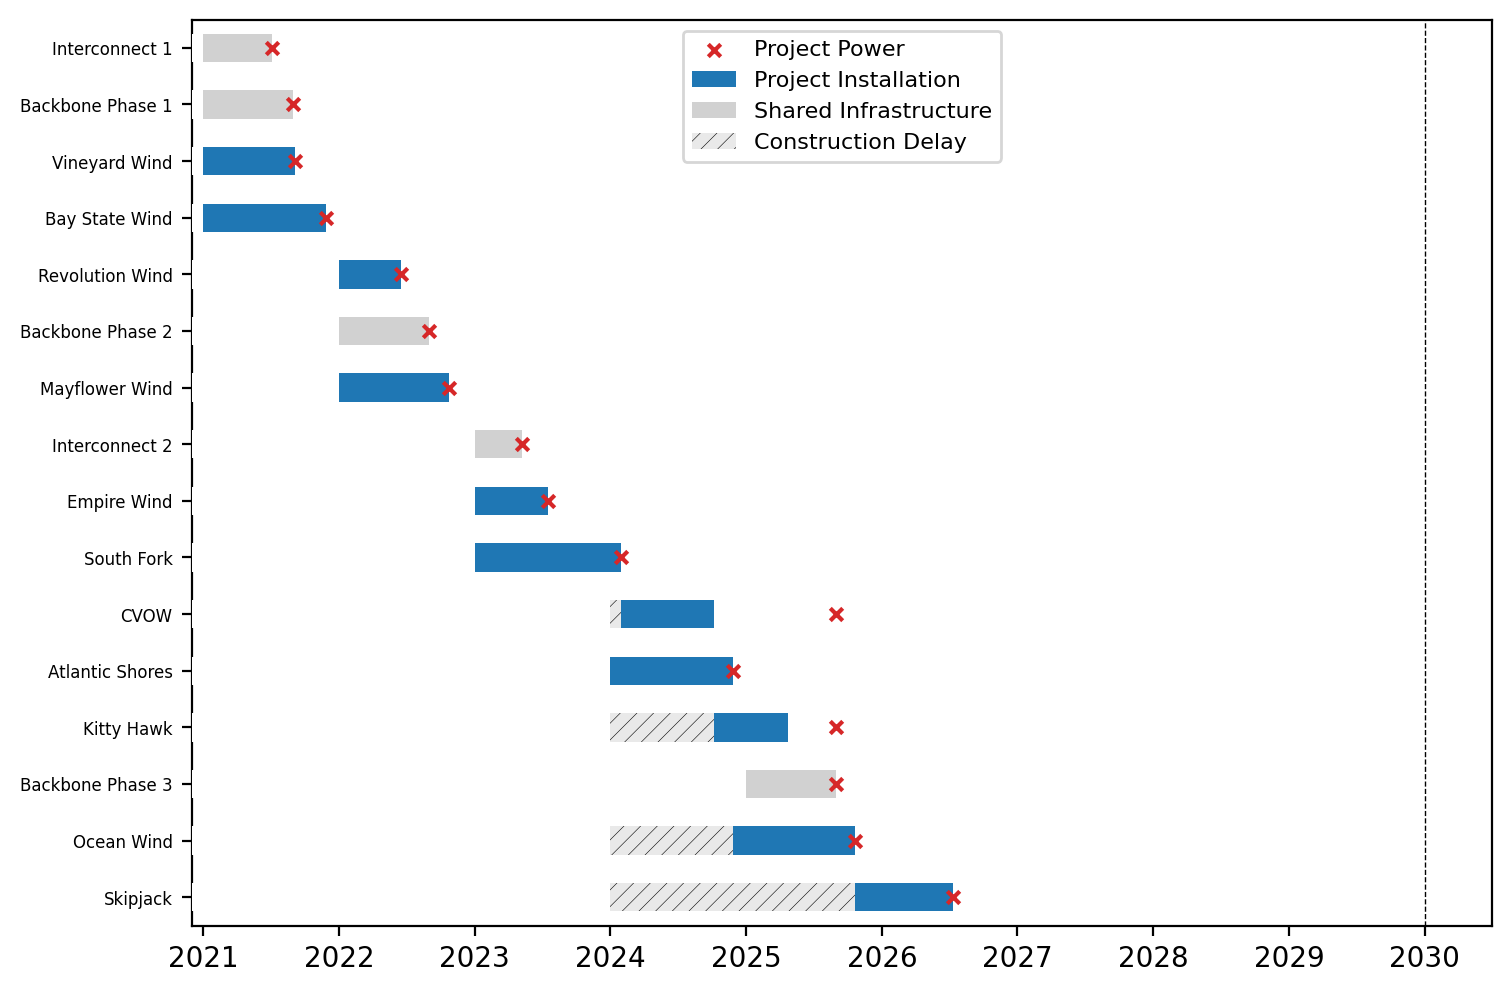

In [24]:
fig = plt.figure(figsize=(10, 6), dpi=200)
ax = fig.add_subplot(111)

shared_mask = df.copy()
shared_mask.loc[~shared_mask["name"].isin(list(infra_pipeline.phases["name"])), "Date Finished"] = pd.Timestamp(2000, 1, 1)

df["Date Finished"].plot(kind="barh", ax=ax, zorder=4, label="Project Installation", color="tab:blue")
shared_mask["Date Finished"].plot(kind="barh", ax=ax, zorder=5, label="Shared Infrastructure", color="#d1d1d1")
df["Date Started"].plot(kind="barh", color="#e9e9e9", ax=ax, zorder=6, label="Construction Delay", hatch="////", linewidth=0.5)
df["Date Initialized"].plot(kind='barh', ax=ax, zorder=7, label="__nolabel__", color='w')

df.plot(kind="scatter", x="Date Powered", y="index", color='tab:red', ax=ax, zorder=8, label="Project Power", marker="x")

ax.axvline(dt.date(2030, 1, 1), lw=0.5, ls="--", color="k", zorder=6)
    
# Plot formatting
ax.set_xlabel("")
ax.set_ylabel("")
_ = ax.set_yticklabels(df['name'])
plt.yticks(fontsize=6)
ax.legend(fontsize=8)
ax.set_xlim(manager._start - dt.timedelta(days=30), dt.date(2030, 6, 1) + dt.timedelta(days=30))#df["Date Finished"].max() + dt.timedelta(days=30))

# installed_capacity = get_installed_capacity_by(df, 2030)
# ax.text(x=dt.date(2032, 8, 1), y=27, s=f"Capacity Installed by 2030:\n     {installed_capacity:,.0f} MW", fontsize=8)

fig.subplots_adjust(left=0.25)